In [1]:
import pandas as pd
import numpy as np
import tensorflow
import tensorflow as tf
from collections import Counter
import tqdm
import re
import json
from datasets import Dataset
import os
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split 

In [2]:
df_train_path= "/aiffel/aiffel/DLthon/train.csv" 
df_test_path = "/aiffel/aiffel/DLthon/test.csv" 
df_general_path = "/aiffel/aiffel/DLthon/final_data.csv"

df_train = pd.read_csv(df_train_path)
test_data = pd.read_csv(df_test_path)

In [3]:
df_train.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
max(df_train['conversation'].apply(len))

874

In [5]:
df_general_path = "/aiffel/aiffel/DLthon/final_data.csv"
df_new = pd.read_csv(df_general_path, encoding='cp949')
df_new.head(3)

,conversation,class,class_encoded
0,너 왜 손가락이 네개야?\n어???\n와 진짜 신기하다\n보지마.\n아니 신기해서 ...,기타 괴롭힘 대화,3.0
1,그 길동구 국회의원님 비서분 되시죠? 네 맞습니다. 무슨 무슨 용건으로 전화 주셨습...,갈취 대화,1.0
2,너가 내 여자친구 좋아한다고 했냐?\n 와 저런 오타쿠가 그랬다고? 꼴값이다 진짜....,기타 괴롭힘 대화,3.0


In [6]:
df_new = df_new.drop('class_encoded', axis=1)
df_new[df_new['class'] == '일반 대화'].head()

,conversation,class
3,제주도에서 하면 벅수 못 갈 꺼 같은디...\nㅠㅠ 벅수 ㅠㅠ\n잠깐 어머니한테 ...,일반 대화
4,물은 어디에 있어요? 창가 쪽에 있어요,일반 대화
5,혹시 세트메뉴는 없나요? 커플 세트와 가족 세트가 있습니다,일반 대화
6,아 그러면 몇 시까지 배달하시는데요? 예 보통 한 20분 정도 되면 끝냅니다,일반 대화
7,오이 빼주실 수 있으세요? 네 가능합니다,일반 대화


In [7]:
df_new = pd.concat([df_train, df_new], ignore_index=True)
df_new['idx'] = df_new.index
df_new.shape

(20645, 3)

In [8]:
df_new

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
20640,20640,일반 대화,"＂자, 먼저 팽이버섯 2봉지를 준비했는데요.＂\n＂팽이버섯은 밑동을 자른 뒤 한 번..."
20641,20641,일반 대화,"＂자, 이 정도로 볶아졌으면 양념 재료를 넣어 볼게요.＂\n＂처음으로 넣는 재료는 ..."
20642,20642,일반 대화,"＂저는 저 마늘빵을 어디에 돌릴지 궁금해요.＂\n＂전자레인지, 오븐, 에어프라이어,..."
20643,20643,일반 대화,＂젊고 건강하게 살고 싶다면 3대 호르몬을 관리해라.＂ \n＂첫 번째로 알아볼 호르...


In [9]:
# 각 문장의 길이를 계산
df_new['length'] = df_new['conversation'].apply(len)
df_new.head()

,idx,class,conversation,length
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,242
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,188
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,218
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,115
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,460


In [10]:
max(df_new['length'])

2574

In [11]:
# 노이즈 데이터제 거
df_new = df_new[df_new['length'] < 900]
print(df_new.shape)

(20530, 4)


In [12]:
class_distribution = df_new['class'].value_counts()
print(class_distribution)

일반 대화          9236
기타 괴롭힘 대화      3020
갈취 대화          2849
직장 내 괴롭힘 대화    2831
협박 대화          2594
Name: class, dtype: int64


In [13]:
removed = df_new.drop_duplicates(subset=['conversation']).reset_index(drop=True)
print(f"기존: {df_new.shape[0]}")
print(f"중복 제거 후: {removed.shape[0]}")

df_new = removed

기존: 20530
중복 제거 후: 16926


In [14]:
import re
df_new['conversation'] = df_new['conversation'].apply(lambda x: re.sub(r'[“”"＂]', '', x))
df_new

,idx,class,conversation,length
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,242
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,188
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,218
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,115
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,460
...,...,...,...,...
16921,20639,일반 대화,"자, 먼저 육개장 필수인 고기를 준비해야겠죠.\n육개장은 보통 사태나 양지를 쓰는 ...",496
16922,20640,일반 대화,"자, 먼저 팽이버섯 2봉지를 준비했는데요.\n팽이버섯은 밑동을 자른 뒤 한 번 헹궈...",585
16923,20641,일반 대화,"자, 이 정도로 볶아졌으면 양념 재료를 넣어 볼게요.\n처음으로 넣는 재료는 바로 ...",452
16924,20642,일반 대화,"저는 저 마늘빵을 어디에 돌릴지 궁금해요.\n전자레인지, 오븐, 에어프라이어, 어떤...",229


In [15]:
# 여기서부터 입력 방식 3조 코드와 동일 (모델은 1조 모델)
train_data = df_new

In [16]:
train_data['class'].unique()


array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '일반 대화'],
      dtype=object)

In [17]:
label = {'협박 대화' : 0, '갈취 대화' : 1, '직장 내 괴롭힘 대화' :2, '기타 괴롭힘 대화' : 3, '일반 대화' : 4}


In [18]:
train_data['int_class'] = train_data['class'].map(label)


In [19]:
train_data

,idx,class,conversation,length,int_class
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,242,0
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,188,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,218,3
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,115,1
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,460,1
...,...,...,...,...,...
16921,20639,일반 대화,"자, 먼저 육개장 필수인 고기를 준비해야겠죠.\n육개장은 보통 사태나 양지를 쓰는 ...",496,4
16922,20640,일반 대화,"자, 먼저 팽이버섯 2봉지를 준비했는데요.\n팽이버섯은 밑동을 자른 뒤 한 번 헹궈...",585,4
16923,20641,일반 대화,"자, 이 정도로 볶아졌으면 양념 재료를 넣어 볼게요.\n처음으로 넣는 재료는 바로 ...",452,4
16924,20642,일반 대화,"저는 저 마늘빵을 어디에 돌릴지 궁금해요.\n전자레인지, 오븐, 에어프라이어, 어떤...",229,4


In [20]:
train_data

,idx,class,conversation,length,int_class
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,242,0
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,188,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,218,3
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,115,1
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,460,1
...,...,...,...,...,...
16921,20639,일반 대화,"자, 먼저 육개장 필수인 고기를 준비해야겠죠.\n육개장은 보통 사태나 양지를 쓰는 ...",496,4
16922,20640,일반 대화,"자, 먼저 팽이버섯 2봉지를 준비했는데요.\n팽이버섯은 밑동을 자른 뒤 한 번 헹궈...",585,4
16923,20641,일반 대화,"자, 이 정도로 볶아졌으면 양념 재료를 넣어 볼게요.\n처음으로 넣는 재료는 바로 ...",452,4
16924,20642,일반 대화,"저는 저 마늘빵을 어디에 돌릴지 궁금해요.\n전자레인지, 오븐, 에어프라이어, 어떤...",229,4


In [21]:
import torch
from torch.utils.data import DataLoader
from transformers import ElectraForSequenceClassification, ElectraTokenizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

In [21]:
from transformers import ElectraModel, ElectraTokenizer
from transformers import ElectraTokenizer,ElectraForSequenceClassification

# Electra small 
model_name = "monologg/koelectra-small-discriminator"
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=5,output_attentions=True) # 어텐션 스코어 반환 활성화
tokenizer = ElectraTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5) # 3e-5, 4e-5
#criterion = torch.nn.CrossEntropyLoss()

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-discriminator and are newly initialized: ['cl

Downloading:   0%|          | 0.00/273k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

### Large model with Dense layer 1 + Classifier fine-tuning was the best

In [46]:
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.electra.encoder.layer[-6].parameters():  # 마지막 6개 레이어 for small model
#     param.requires_grad = True

# for param in model.classifier.parameters():  # classifier 레이어
#     param.requires_grad = True

for param in model.parameters():
    param.requires_grad = True

In [47]:
from sklearn.model_selection import train_test_split

X = train_data['conversation']
y = train_data['int_class']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

In [48]:
X_train.tolist()[0]

'언니 지금 자차 있다고 그랬나?\n아니 없어 있었음 좋겠다\n언니는 당장 차 살 생각 없어?\n차 사고야 싶지 근데 돈이 없디\n그렇지 ㅜㅜ\n내 친구는 이번에 뽑았대,\n부럽다\n할부로?\n어떻게 샀데\n아니 엄마가 사줬대, 부럽다,\n와 금수저 난 안 사주나\n키키 어무니가 같이 타자고 사줬대!\n좋겠다\n차 있음 좋지\n맞아 아반떼 신형이던데, 이쁘드라,\n와 아반떼 괜찮던데 여자가 타기 좋지\n맞아, 색이 근데 좀 특이했어 검은색 같은데 검은색이 아니래!\n키키 그건 뭔 색이야?\n여튼 좋겠네\n그러니까 메탈블루인가?\n요즘에 특이한 이름의 색이 많이 나와!\n전기차가 많이 보이더라 요즘은'

In [49]:
# 먼저 encode_data 함수에서 input_ids 반환
def encode_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
#     print(encodings)
    # print(len(encodings['attention_mask']))
    return torch.tensor(encodings['input_ids']), torch.tensor(labels)
# 텍스트에 대한 토큰화된 input_ids와 라벨 얻기
input_test = encode_data(X_train.tolist()[0], y_train.tolist()[0])

In [50]:
def encode_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=200)
    return torch.tensor(encodings['input_ids']), torch.tensor(labels)

train_inputs, train_labels = encode_data(X_train.tolist(), y_train.tolist())
val_inputs, val_labels = encode_data(X_test.tolist(), y_test.tolist())

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [51]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()  
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=-1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_preds / total_preds

    return avg_loss, accuracy

def evaluate(model, val_dataloader, criterion):
    model.eval()  
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = logits.argmax(dim=-1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, classification_report(all_labels, all_preds)

Epoch 1/5


Training: 100%|██████████| 1693/1693 [01:35<00:00, 17.81it/s]


Train Loss: 0.6194, Train Accuracy: 0.7292


Evaluating: 100%|██████████| 424/424 [00:07<00:00, 57.54it/s]


Validation Loss: 0.3187, Validation Accuracy: 0.8898, F1 Score: 0.8841
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       357
           1       0.64      0.97      0.77       389
           2       0.91      0.92      0.91       388
           3       0.91      0.43      0.58       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.89      3386
   macro avg       0.83      0.81      0.80      3386
weighted avg       0.91      0.89      0.88      3386

Epoch 2/5


Training: 100%|██████████| 1693/1693 [01:34<00:00, 17.84it/s]


Train Loss: 0.2213, Train Accuracy: 0.9273


Evaluating: 100%|██████████| 424/424 [00:07<00:00, 57.03it/s]


Validation Loss: 0.2795, Validation Accuracy: 0.9082, F1 Score: 0.9042
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.93      0.75       357
           1       0.78      0.93      0.85       389
           2       0.99      0.91      0.95       388
           3       0.96      0.46      0.62       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.91      3386
   macro avg       0.87      0.85      0.83      3386
weighted avg       0.93      0.91      0.90      3386

Epoch 3/5


Training: 100%|██████████| 1693/1693 [01:34<00:00, 17.83it/s]


Train Loss: 0.1247, Train Accuracy: 0.9622


Evaluating: 100%|██████████| 424/424 [00:07<00:00, 56.77it/s]


Validation Loss: 0.1064, Validation Accuracy: 0.9672, F1 Score: 0.9671
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90       357
           1       0.91      0.92      0.92       389
           2       0.98      0.98      0.98       388
           3       0.88      0.96      0.91       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.97      3386
   macro avg       0.94      0.94      0.94      3386
weighted avg       0.97      0.97      0.97      3386

Epoch 4/5


Training: 100%|██████████| 1693/1693 [01:34<00:00, 17.83it/s]


Train Loss: 0.0790, Train Accuracy: 0.9763


Evaluating: 100%|██████████| 424/424 [00:07<00:00, 57.08it/s]


Validation Loss: 0.0854, Validation Accuracy: 0.9755, F1 Score: 0.9754
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       357
           1       0.93      0.96      0.94       389
           2       0.96      0.99      0.97       388
           3       0.96      0.93      0.95       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.98      3386
   macro avg       0.96      0.96      0.96      3386
weighted avg       0.98      0.98      0.98      3386

Epoch 5/5


Training: 100%|██████████| 1693/1693 [01:34<00:00, 17.83it/s]


Train Loss: 0.0572, Train Accuracy: 0.9821


Evaluating: 100%|██████████| 424/424 [00:07<00:00, 57.30it/s]


Validation Loss: 0.2058, Validation Accuracy: 0.9418, F1 Score: 0.9425
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80       357
           1       0.95      0.67      0.78       389
           2       0.99      0.98      0.98       388
           3       0.97      0.88      0.92       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.94      3386
   macro avg       0.92      0.90      0.90      3386
weighted avg       0.95      0.94      0.94      3386



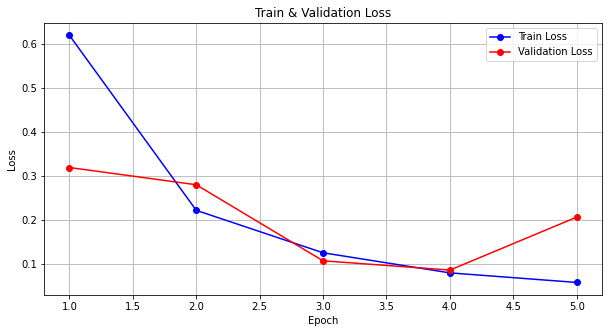

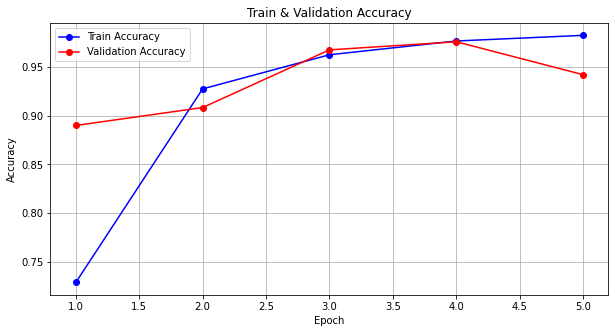

In [52]:

import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 5 

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy, val_f1, val_report = evaluate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
    print("Classification Report:\n", val_report)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue", marker="o")
ax1.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train & Validation Loss")
ax1.legend()
ax1.grid()

plt.show()

fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color="blue", marker="o")
ax2.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="red", marker="o")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Train & Validation Accuracy")
ax2.legend()
ax2.grid()

plt.show()

In [62]:
testset = test_data
testset['text'] = testset['text']
testset  = pd.DataFrame(testset)
X = testset['text']

In [63]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to('cpu')

texts = X.tolist()
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)


inputs_updated = {}
for key, value in inputs.items():
#     inputs_updated[key] = value.to(device)
    inputs_updated[key] = value.to('cpu')

with torch.no_grad():
    outputs = model(
        input_ids=inputs_updated["input_ids"],
        token_type_ids=inputs_updated["token_type_ids"],
        attention_mask=inputs_updated["attention_mask"]
    )

# inputs = {key: value.to(device) for key, value in inputs.items()}
# with torch.no_grad():
#     outputs = model(**inputs)

predictions = torch.argmax(outputs.logits, dim=1)
print(predictions)

tensor([1, 2, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 2, 2, 2, 3, 0, 3, 0, 3, 0, 3, 3, 0,
        1, 2, 0, 3, 2, 0, 1, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0, 1, 2, 1, 3, 2, 0, 3,
        4, 0, 1, 3, 1, 2, 2, 3, 3, 4, 3, 3, 1, 3, 0, 2, 2, 0, 3, 3, 0, 0, 3, 2,
        3, 2, 0, 2, 2, 1, 2, 3, 0, 0, 0, 0, 0, 2, 0, 3, 1, 2, 0, 2, 0, 4, 3, 2,
        4, 2, 0, 0, 1, 0, 3, 0, 0, 2, 2, 3, 3, 0, 0, 0, 0, 2, 1, 0, 4, 2, 2, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 4, 3, 3, 2, 3, 0, 0, 0, 0, 3, 2, 3, 3, 1, 3,
        0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 1, 3, 0, 2, 3, 3, 0, 3, 2, 0, 3, 3, 2, 4,
        3, 1, 0, 2, 2, 3, 0, 3, 0, 2, 0, 1, 2, 3, 2, 2, 0, 3, 2, 0, 1, 0, 0, 3,
        1, 3, 1, 0, 0, 3, 0, 3, 2, 0, 3, 2, 0, 3, 2, 1, 2, 2, 0, 1, 0, 2, 0, 3,
        3, 4, 0, 0, 1, 2, 0, 0, 0, 3, 1, 0, 1, 0, 2, 0, 0, 1, 0, 3, 0, 1, 0, 3,
        3, 3, 3, 2, 3, 1, 2, 1, 2, 0, 0, 3, 0, 2, 2, 1, 0, 2, 1, 2, 1, 3, 0, 3,
        2, 3, 3, 3, 3, 1, 0, 3, 0, 2, 1, 2, 2, 3, 2, 2, 1, 0, 3, 2, 4, 2, 0, 2,
        0, 3, 1, 1, 3, 3, 2, 0, 3, 0, 0,

In [64]:
import pandas as pd
import json

# 예시로 주어진 output_dict 생성
output_dict = {}

for idx, pred in enumerate(predictions):
    # 예측된 클래스 인덱스를 문자로 변환 (예: '01', '02', ...)
    class_id = f"{pred.item():02d}"
    key = f"t_{idx:03d}"
    
    output_dict[key] = {"class": class_id}

df_new = pd.DataFrame.from_dict(output_dict, orient='index')
df_new['target'] = df_new['class'].apply(lambda x: int(x))  # 'class'를 정수형으로 변환
df_new['idx'] = df_new.index

df_new = df_new[['idx', 'target']]

output_path = "/aiffel/aiffel/DLthon/result_Feb22_KoElectra-v3_10epoch.csv" 
df_new.to_csv(output_path, index=False, header=True, encoding='utf-8') 

df_new.head()

,idx,target
t_000,t_000,1
t_001,t_001,2
t_002,t_002,3
t_003,t_003,3
t_004,t_004,3


In [ ]:
#0.62214

### Test2 lr, max_length 맞춰서 해보기 

In [87]:
from transformers import ElectraModel, ElectraTokenizer
from transformers import ElectraTokenizer,ElectraForSequenceClassification

# Electra small 
model_name = "monologg/koelectra-small-discriminator"
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=5,output_attentions=True) # 어텐션 스코어 반환 활성화
tokenizer = ElectraTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # 3e-5, 4e-5
criterion = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at monologg/koelectra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-discriminator and are newly initialized: ['cl

In [88]:
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.electra.encoder.layer[-6].parameters():  # 마지막 1개 레이어
#     param.requires_grad = True

# for param in model.classifier.parameters():  # classifier 레이어
#     param.requires_grad = True

for param in model.parameters():
    param.requires_grad = True

In [89]:
from sklearn.model_selection import train_test_split

X = train_data['conversation']
y = train_data['int_class']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # ← 여기서 y를 넣어주면 클래스 비율을 맞춰줍니다.
)

In [92]:
# # 먼저 encode_data 함수에서 input_ids 반환
# max_length = 500
# def encode_data(texts, labels):
#     encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
# #     print(encodings)
#     # print(len(encodings['attention_mask']))
#     return torch.tensor(encodings['input_ids']), torch.tensor(labels)
# # 텍스트에 대한 토큰화된 input_ids와 라벨 얻기
# input_test = encode_data(X_train.tolist()[0], y_train.tolist()[0])

In [93]:
max_length = 500

def encode_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    return torch.tensor(encodings['input_ids']), torch.tensor(labels)

train_inputs, train_labels = encode_data(X_train.tolist(), y_train.tolist())
val_inputs, val_labels = encode_data(X_test.tolist(), y_test.tolist())

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [100]:
print(model)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32200, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [101]:
total_params = sum(p.numel() for p in model.parameters())
print(f"전체 파라미터 수: {total_params}")

전체 파라미터 수: 13764869


In [94]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()  
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=-1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_preds / total_preds

    return avg_loss, accuracy

def evaluate(model, val_dataloader, criterion):
    model.eval()  
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = logits.argmax(dim=-1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, classification_report(all_labels, all_preds)

Epoch 1/5


Training: 100%|██████████| 1693/1693 [03:44<00:00,  7.55it/s]


Train Loss: 0.7068, Train Accuracy: 0.7089


Evaluating: 100%|██████████| 424/424 [00:19<00:00, 22.17it/s]


Validation Loss: 0.4735, Validation Accuracy: 0.7670, F1 Score: 0.7202
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07       357
           1       0.35      0.89      0.51       389
           2       0.75      0.95      0.84       388
           3       0.40      0.06      0.11       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.77      3386
   macro avg       0.70      0.59      0.51      3386
weighted avg       0.83      0.77      0.72      3386

Epoch 2/5


Training: 100%|██████████| 1693/1693 [03:45<00:00,  7.52it/s]


Train Loss: 0.3749, Train Accuracy: 0.8585


Evaluating: 100%|██████████| 424/424 [00:19<00:00, 22.18it/s]


Validation Loss: 0.2258, Validation Accuracy: 0.9235, F1 Score: 0.9221
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.92      0.82       357
           1       0.88      0.76      0.81       389
           2       0.89      0.98      0.94       388
           3       0.83      0.68      0.75       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.92      3386
   macro avg       0.87      0.87      0.86      3386
weighted avg       0.93      0.92      0.92      3386

Epoch 3/5


Training: 100%|██████████| 1693/1693 [03:45<00:00,  7.52it/s]


Train Loss: 0.1785, Train Accuracy: 0.9421


Evaluating: 100%|██████████| 424/424 [00:19<00:00, 22.22it/s]


Validation Loss: 0.1658, Validation Accuracy: 0.9418, F1 Score: 0.9417
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83       357
           1       0.89      0.87      0.88       389
           2       0.98      0.97      0.98       388
           3       0.93      0.71      0.80       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.94      3386
   macro avg       0.91      0.90      0.90      3386
weighted avg       0.95      0.94      0.94      3386

Epoch 4/5


Training: 100%|██████████| 1693/1693 [03:45<00:00,  7.52it/s]


Train Loss: 0.1066, Train Accuracy: 0.9679


Evaluating: 100%|██████████| 424/424 [00:19<00:00, 22.22it/s]


Validation Loss: 0.1424, Validation Accuracy: 0.9557, F1 Score: 0.9555
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88       357
           1       0.93      0.85      0.89       389
           2       0.95      0.99      0.97       388
           3       0.80      0.97      0.88       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.96      3386
   macro avg       0.93      0.92      0.92      3386
weighted avg       0.96      0.96      0.96      3386

Epoch 5/5


Training: 100%|██████████| 1693/1693 [03:44<00:00,  7.53it/s]


Train Loss: 0.0733, Train Accuracy: 0.9790


Evaluating: 100%|██████████| 424/424 [00:19<00:00, 22.16it/s]


Validation Loss: 0.1069, Validation Accuracy: 0.9666, F1 Score: 0.9665
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       357
           1       0.97      0.89      0.93       389
           2       0.90      1.00      0.95       388
           3       0.94      0.89      0.91       404
           4       1.00      1.00      1.00      1848

    accuracy                           0.97      3386
   macro avg       0.94      0.94      0.94      3386
weighted avg       0.97      0.97      0.97      3386



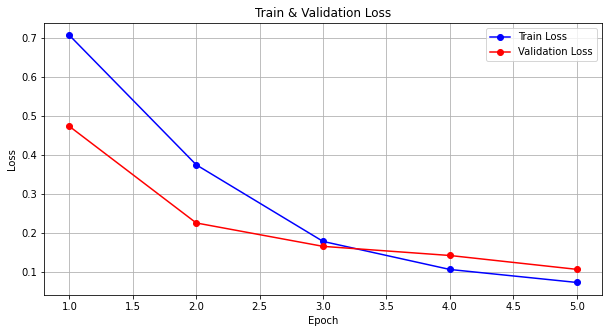

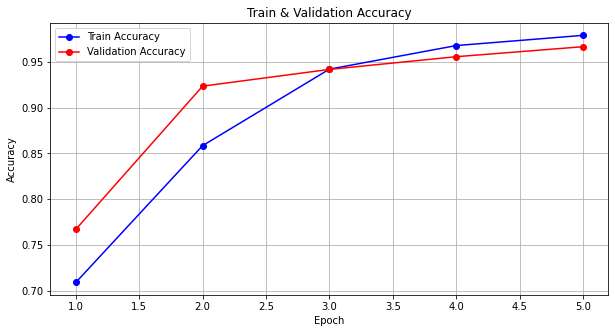

In [95]:

import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 5  

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy, val_f1, val_report = evaluate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
    print("Classification Report:\n", val_report)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue", marker="o")
ax1.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train & Validation Loss")
ax1.legend()
ax1.grid()

plt.show()

fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color="blue", marker="o")
ax2.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="red", marker="o")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Train & Validation Accuracy")
ax2.legend()
ax2.grid()

plt.show()

In [97]:
testset
testset['text'] = testset['text']
testset  = pd.DataFrame(testset)
X = testset['text']

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to('cpu')

texts = X.tolist()
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)


inputs_updated = {}
for key, value in inputs.items():
#     inputs_updated[key] = value.to(device)
    inputs_updated[key] = value.to('cpu')

with torch.no_grad():
    outputs = model(
        input_ids=inputs_updated["input_ids"],
        token_type_ids=inputs_updated["token_type_ids"],
        attention_mask=inputs_updated["attention_mask"]
    )

# inputs = {key: value.to(device) for key, value in inputs.items()}
# with torch.no_grad():
#     outputs = model(**inputs)

predictions = torch.argmax(outputs.logits, dim=1)
print(predictions)

tensor([1, 2, 2, 3, 3, 0, 0, 3, 3, 1, 0, 2, 2, 2, 2, 3, 0, 3, 0, 3, 0, 3, 3, 1,
        1, 2, 3, 2, 2, 0, 1, 0, 2, 2, 3, 3, 3, 0, 0, 1, 0, 1, 2, 1, 3, 2, 0, 3,
        4, 0, 1, 3, 1, 2, 2, 3, 3, 4, 3, 2, 1, 3, 0, 3, 2, 0, 2, 3, 4, 0, 2, 2,
        3, 2, 0, 2, 2, 1, 2, 2, 3, 0, 2, 0, 3, 2, 0, 3, 1, 2, 2, 2, 0, 3, 3, 2,
        2, 2, 0, 2, 1, 1, 4, 0, 2, 2, 2, 3, 3, 0, 0, 0, 0, 2, 1, 1, 4, 2, 2, 1,
        2, 3, 1, 1, 1, 0, 2, 2, 1, 3, 3, 3, 2, 3, 1, 0, 0, 0, 3, 2, 3, 3, 1, 3,
        2, 0, 0, 0, 3, 1, 0, 3, 0, 1, 2, 2, 0, 2, 3, 3, 0, 3, 2, 0, 2, 3, 2, 4,
        3, 1, 0, 2, 2, 3, 3, 3, 2, 2, 3, 1, 2, 3, 2, 2, 2, 3, 2, 0, 1, 0, 0, 3,
        1, 2, 1, 3, 0, 4, 0, 2, 2, 0, 3, 2, 0, 3, 2, 2, 2, 2, 0, 1, 2, 2, 1, 3,
        4, 4, 3, 0, 1, 2, 0, 2, 0, 4, 1, 0, 1, 0, 2, 0, 3, 3, 1, 3, 3, 1, 0, 3,
        3, 3, 2, 2, 2, 1, 2, 3, 2, 0, 0, 2, 0, 2, 2, 3, 3, 2, 1, 2, 2, 3, 2, 3,
        2, 3, 3, 4, 2, 3, 0, 3, 0, 2, 4, 2, 2, 3, 2, 2, 1, 0, 3, 2, 4, 2, 0, 2,
        0, 3, 1, 1, 3, 3, 2, 0, 3, 3, 1,

In [98]:
import pandas as pd
import json

# 예시로 주어진 output_dict 생성
output_dict = {}

for idx, pred in enumerate(predictions):
    # 예측된 클래스 인덱스를 문자로 변환 (예: '01', '02', ...)
    class_id = f"{pred.item():02d}"
    key = f"t_{idx:03d}"
    
    output_dict[key] = {"class": class_id}

df_new = pd.DataFrame.from_dict(output_dict, orient='index')
df_new['target'] = df_new['class'].apply(lambda x: int(x))  # 'class'를 정수형으로 변환
df_new['idx'] = df_new.index

df_new = df_new[['idx', 'target']]

output_path = "/aiffel/aiffel/DLthon/result_Feb22_KoElectra-v3_10epoch.csv" 
df_new.to_csv(output_path, index=False, header=True, encoding='utf-8') 

df_new.head()

,idx,target
t_000,t_000,1
t_001,t_001,2
t_002,t_002,2
t_003,t_003,3
t_004,t_004,3


In [ ]:
#0.67382

### Test 3 배치사이즈 조절

In [22]:
from transformers import ElectraModel, ElectraTokenizer
from transformers import ElectraTokenizer,ElectraForSequenceClassification

# Electra small 
model_name = "monologg/koelectra-small-discriminator"
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=5,output_attentions=True) # 어텐션 스코어 반환 활성화
tokenizer = ElectraTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # 3e-5, 4e-5
criterion = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at monologg/koelectra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-discriminator and are newly initialized: ['cl

In [32]:
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.electra.encoder.layer[-6].parameters():  # 마지막 1개 레이어
#     param.requires_grad = True

# for param in model.classifier.parameters():  # classifier 레이어
#     param.requires_grad = True

for param in model.parameters():
    param.requires_grad = True

In [35]:
max_length = 500

def encode_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    return torch.tensor(encodings['input_ids']), torch.tensor(labels)

train_inputs, train_labels = encode_data(X_train.tolist(), y_train.tolist())
val_inputs, val_labels = encode_data(X_test.tolist(), y_test.tolist())

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [36]:

import matplotlib.pyplot as plt

# 학습 과정에서 기록할 변수들
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 5  # 총 학습 epoch

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Evaluation
    val_loss, val_accuracy, val_f1, val_report = evaluate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
    print("Classification Report:\n", val_report)

fig, ax1 = plt.subplots(figsize=(10, 5))

# 손실(loss) 그래프
ax1.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue", marker="o")
ax1.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Train & Validation Loss")
ax1.legend()
ax1.grid()

plt.show()

# 📈 정확도(accuracy) 그래프
fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color="blue", marker="o")
ax2.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="red", marker="o")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Train & Validation Accuracy")
ax2.legend()
ax2.grid()

plt.show()

Epoch 1/5


Training:   0%|          | 0/424 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 88.00 MiB (GPU 0; 14.58 GiB total capacity; 12.97 GiB already allocated; 9.56 MiB free; 13.37 GiB reserved in total by PyTorch)